# QSP Demo: Two Perspectives

In this notebook we explore **Quantum Signal Processing (QSP)** in two ways:

**Part A**: QSP (scalar QSVT)  
   - We use PennyLane's `qml.qsvt` on a scalar input.
   - Mathematically, QSVT *reduces to QSP* when acting on a scalar.

**Part B**: Manual QSP-style circuit
   - We build a simple 1-qubit circuit with repeated rotations.
   - This circuit implements a **Chebyshev polynomial**:
     $$ T_3(x) = 4x^3 - 3x. $$

We use Chebyshev polynomial because they are the optimal for approximating functions in $[-1,1]$, and $T_3(x)$ above is the simplest non-trivial polynomial.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


## Part A: QSP via QSVT on a Scalar

QSVT is a general framework for transforming singular values of a block-encoded
operator via polynomial functions.

When the "operator" is just a **scalar** $x \in [-1,1]$, the QSVT construction
reduces to applying a **polynomial of x** — this is QSP.

We will implement the polynomial

$$ f(x) = x^3 $$

using `qml.qsvt`.

In [2]:
def exact_poly(x):
    return x**3

# Target polynomial: f(x) = x^3
target_poly = [0, 0, 0, 1]


def qsvt_scalar_output(x):
    """Apply QSVT to a scalar x with polynomial f(x) = x^3."""
    op = qml.qsvt(x, target_poly, encoding_wires=[0], block_encoding="embedding")
    U = qml.matrix(op)
    return np.real(U[0, 0])   # top-left element encodes f(x)


## Evaluating QSVT on Scalars

We now evaluate:

- the **QSVT-implemented polynomial** via `qsvt_scalar_output(x)`, and
- the **exact polynomial** $x^3$,

for many values of $x \in [-1,1]$, and compare them.


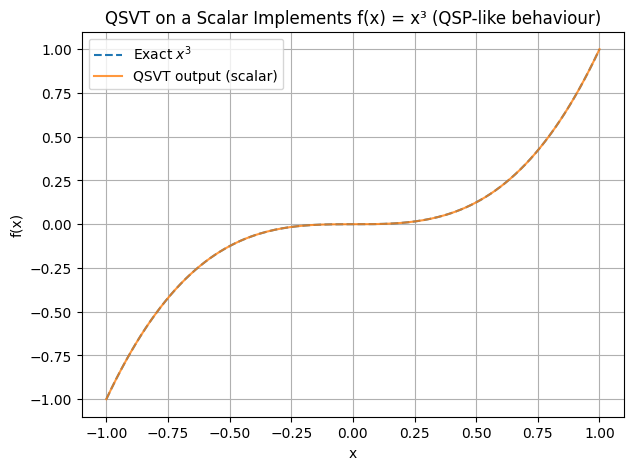

In [3]:
x_vals = np.linspace(-1, 1, 200)
qsvt_vals = np.array([qsvt_scalar_output(x) for x in x_vals])
exact_vals = exact_poly(x_vals)

plt.figure(figsize=(7,5))
plt.plot(x_vals, exact_vals, "--", label="Exact $x^3$")
plt.plot(x_vals, qsvt_vals, "-", alpha=0.8, label="QSVT output (scalar)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("QSVT on a Scalar Implements f(x) = x³ (QSP-like behaviour)")
plt.grid(True)
plt.legend()
plt.show()


What we see:

- The **QSVT output** matches the curve $x^3$ extremely well.
- For scalar inputs, QSVT is effectively **QSP acting on a single singular value**.
- The polynomial constraint $|f(x)| \le 1$ on $[-1,1]$ is satisfied by $x^3$.

This shows how QSVT/QSP let us implement **polynomial functions of a scalar parameter**
using quantum circuits.

Next, we turn to a **manual QSP-style circuit**, where we build a polynomial
using repeated single-qubit rotations.


## Part B: Manual QSP-style Circuit

Here we construct a simple 1-qubit circuit that exactly implements the Chebyshev polynomial:

$$
T_3(x) = 4x^3 - 3x,
$$

the third Chebyshev polynomial (simplest non-trivial case).

For the rotation operator:

$$
R_y(2\theta) =
\begin{pmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{pmatrix},
$$

if we choose $x = \cos\theta$, then for $n=3$:

$$
\left[ R_y(2\theta)^3 \right]_{0,0} = \cos(3\theta) = T_3(\cos\theta) = T_3(x).
$$

So by repeating `RY(2θ)` three times with $\theta = \arccos(x)$, the top-left
matrix element of the effective unitary implements exactly $T_3(x)$.


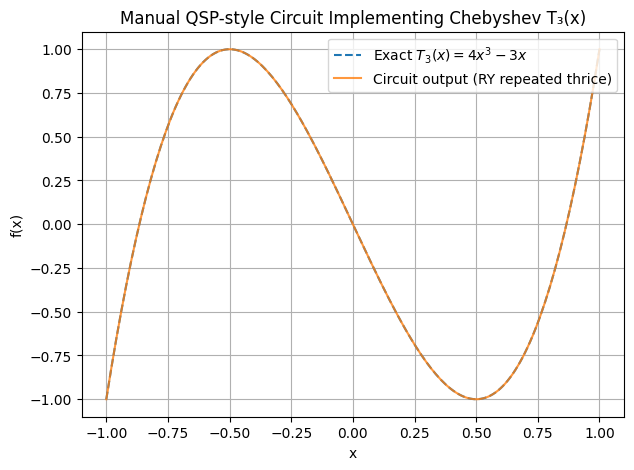

In [4]:
dev = qml.device("default.qubit", wires=1)


@qml.qnode(dev)
def chebyshev_circuit(theta):
    """Apply RY(2*theta) three times and return the full state."""
    for _ in range(3):
        qml.RY(2 * theta, wires=0)
    return qml.state()


def chebyshev_output(x):
    """Compute the top-left amplitude corresponding to T3(x)."""
    theta = np.arccos(x)
    state = chebyshev_circuit(theta)
    # State is [alpha, beta], with alpha = cos(3*theta) = T3(x)
    return np.real(state[0])


def T3(x):
    """Chebyshev polynomial T3(x) = 4x^3 - 3x."""
    return 4*x**3 - 3*x

x_vals = np.linspace(-1, 1, 200)
circ_vals = np.array([chebyshev_output(x) for x in x_vals])
T3_vals = T3(x_vals)

# Plotting the results
plt.figure(figsize=(7,5))
plt.plot(x_vals, T3_vals, "--", label="Exact $T_3(x) = 4x^3 - 3x$")
plt.plot(x_vals, circ_vals, "-", alpha=0.8, label="Circuit output (RY repeated thrice)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Manual QSP-style Circuit Implementing Chebyshev T₃(x)")
plt.grid(True)
plt.legend()
plt.show()


This simple circuit shows that:

- Repeated application of a 1-qubit "signal" unitary $R_y(2\theta)$
  builds a **polynomial function** $T_n(x)$ of the parameter $x = \cos\theta$.
- For three repetitions, we get $T_3(x) = 4x^3 - 3x$.
- The **top-left amplitude** of the resulting state encodes the polynomial.

This is a **QSP-style behaviour**:
- a scalar parameter $x$,
- a quantum circuit built from a repeated unitary,
- the output encodes a polynomial in $x$.

Full QSP is more general:
- it uses carefully chosen phase rotations,
- and can implement arbitrary bounded polynomials on $[-1,1]$,
- but the core idea is the same: **polynomials implemented via quantum signal processing**.
